In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import parallel_cordinet_decend_spectral_embbeding as src

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import timeit

import importlib.util
import random

from multiprocessing import Pool


## Introduccion

Estamos buscando una matriz $X$ tal que $XX^T$, considerando una mascarara $M$. 
Entonces buscamos optimizar: $min ||(A-XX^T)*M||_F^2$

Se busca un enfoque de desenso por gradiente

### Datos de ejemplo

Se construye un grafo SBM, utilizando dos grupos, el numero de intgrantes de cada grupo se encuentra en la variable `n_list`. 
Las probabilidades entre y dentro de los grupos se encuentran en la matrix `p1`

Por ultimo se eligue la matriz `X` (Embeedings buscados) inicialmente random, una mascara `M` con todos los elementos menos la identidad (no hay loops en este grafo), y `A` la matriz que contiene la informacion del grafo 

In [4]:
p1 = [[0.5, 0.2],
      [0.2, 0.5]]
d=10
n_list = [4000, 5000]

nt=np.sum(n_list)
g = nx.stochastic_block_model(n_list,p1)
A_original = nx.to_numpy_array(g)
M_original = np.ones(nt) - np.eye(nt)
X_original = np.random.rand(A_original.shape[0],d)


Se realiza una primera prueba de tiempo y error utilizando el algoritmo de Coordinate descent pero serial

Running Coordinate descent
Iteracion: 0 | Error relativo: 0.9515212883049835 | norma R: 2233.8605231679867
Iteracion: 1 | Error relativo: 0.19919745489402668 | norma R: 3511.838957113609
Iteracion: 2 | Error relativo: 0.007969716060457573 | norma R: 3456.7721030544126
Iteracion: 3 | Error relativo: 0.00033158731522046783 | norma R: 3449.404428385904
Iteracion: 4 | Error relativo: 0.00015321306836498752 | norma R: 3451.1436864431435
Iteracion: 5 | Error relativo: 9.492307439641886e-05 | norma R: 3451.618185336658
Iteracion: 6 | Error relativo: 6.516654952373695e-05 | norma R: 3451.692329699797
Iteracion: 7 | Error relativo: 4.762069460988548e-05 | norma R: 3451.7890018713533
Iteracion: 8 | Error relativo: 3.637677262972566e-05 | norma R: 3451.8734977208683
Iteracion: 9 | Error relativo: 2.873543254172422e-05 | norma R: 3451.9377595301517
Iteracion: 10 | Error relativo: 2.3301230703590606e-05 | norma R: 3451.9896582170927
Iteracion: 11 | Error relativo: 1.929340937803915e-05 | norma R: 3

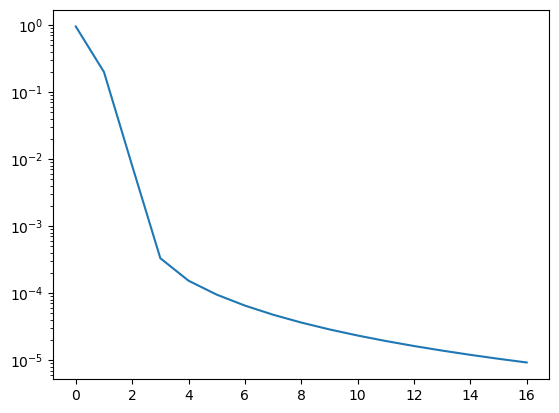

In [74]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent")
start_cd = timeit.default_timer()
(X_cd, errores) = src.coordinate_descent(A,d)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate descent            ",time_cd,"\t\t", src.cost_function(A,X_cd,M))

plt.plot(errores)
plt.yscale('log')
x_star = X_cd

### Procesamiento de los lattent position por bloque


Un primer enfoque que proponemos es intentar procesar un bloque de cordenadas en simultanio, y no de forma serial como se esta realizando hoy en dia. Eso permitira que si el se continua convergiendo, se pueda paralelizar.

Se realiza la implementacion, donde se puede espesificar el numero de batch (numero de cordenadas procesadasen paralelo). Se sortea las filas a procesar en cada iteracion. 
La implementacion se encuentra en `coordinate_descent_random_filas` 

#### Primera prueba (batch = n/16)

Se comienza probando con un batch de $n/16$, el cual en este caso es: 562 filas. Se espera que el numero de iteraciones sea mayor, pero potencialmente se podrian procesar dichas 562 filas en paralelo.

Running Coordinate descent
Iteracion: 0 | Error relativo: 11704332.509293037 | norma R: 2046.8277872943568
Iteracion: 1 | Error relativo: 10002701.675742976 | norma R: 4165.481686269664
Iteracion: 2 | Error relativo: 8306647.120903686 | norma R: 3429.59287387895
Iteracion: 3 | Error relativo: 8299778.554039261 | norma R: 3457.3123108221203
Iteracion: 4 | Error relativo: 8296936.487565898 | norma R: 3449.602118388373
Iteracion: 5 | Error relativo: 8295621.17201142 | norma R: 3452.33239785706
Iteracion: 6 | Error relativo: 8294837.918920166 | norma R: 3451.9217445067165
Iteracion: 7 | Error relativo: 8294294.261550957 | norma R: 3452.2836063846944
Iteracion: 8 | Error relativo: 8293889.963984693 | norma R: 3452.3544574782413
Iteracion: 9 | Error relativo: 8293579.512889274 | norma R: 3452.461574948857
Iteracion: 10 | Error relativo: 8293331.265655389 | norma R: 3452.5376169184447
Iteracion: 11 | Error relativo: 8293128.97175834 | norma R: 3452.5967779407424
Iteracion: 12 | Error relativo

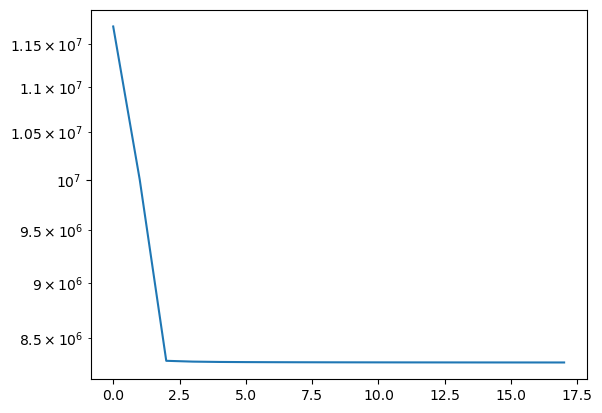

In [16]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent")
start_cd_r = timeit.default_timer()
n = A.shape[0]
(X_cd_r, errores) = src.coordinate_descent_random_filas(A,d,int(n/20), verbose=True)
stop_cd_r = timeit.default_timer()
time_cd_r = round(stop_cd_r-start_cd_r,3)
print("Done in ",time_cd_r," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate descent random            ",time_cd_r,"\t\t", src.cost_function(A,X_cd_r,M))

plt.plot(errores)
plt.yscale('log')


Convergio el 17 iteracion, comparado con las 16 del metodo original. Lo que uno podria pensar que es una gran oportunidad para paralelizar sin gran perdida de de performance en los resultados. Notar que la funcion de costo es similar a la obtenida en el metodo serial.

El siguiente paso es probar con un batch mas grande, en particular $n/2$.   

Running Coordinate descent
Iteracion: 0 | Error relativo: 12858627.894351112 | norma R: 11912.720164603663
Iteracion: 1 | Error relativo: 737944546.4136672 | norma R: 39347.92694193381
Iteracion: 2 | Error relativo: 9102657.587509476 | norma R: 19919.42807606318
Iteracion: 3 | Error relativo: 646900571.6741977 | norma R: 36745.83495287413
Iteracion: 4 | Error relativo: 8558282.206214916 | norma R: 18883.791245390858
Iteracion: 5 | Error relativo: 495088937.43539304 | norma R: 32040.509709517264
Iteracion: 6 | Error relativo: 8368667.706555051 | norma R: 16222.893495641696
Iteracion: 7 | Error relativo: 310959060.60838306 | norma R: 25434.856961930636
Iteracion: 8 | Error relativo: 8311705.873052483 | norma R: 13480.600186404165
Iteracion: 9 | Error relativo: 104360997.13649161 | norma R: 14665.50798018977
Iteracion: 10 | Error relativo: 8301977.867033766 | norma R: 7762.949729782162
Iteracion: 11 | Error relativo: 33895275.12642592 | norma R: 8041.939202994789
Iteracion: 12 | Error rel

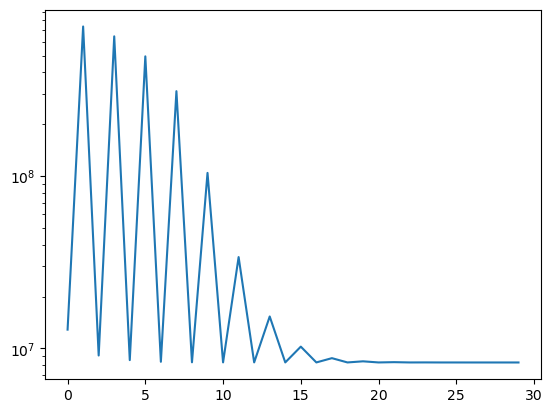

In [13]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent")
start_cd_r = timeit.default_timer()
n = A.shape[0]
(X_cd_r, errores) = src.coordinate_descent_random_filas(A,d,int(n/2), verbose=True)
stop_cd_r = timeit.default_timer()
time_cd_r = round(stop_cd_r-start_cd_r,3)
print("Done in ",time_cd_r," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate descent random            ",time_cd_r,"\t\t", src.cost_function(A,X_cd_r,M))

plt.plot(errores)
plt.yscale('log')


Notar que el numero de iteracion es sensiblemente mas grande, y es constante el desenso.

Se procece a graficar el numero de iteraciones probando con variios tamaños de batch:

Calculando n = 4500
Calculando n = 3000
Calculando n = 2250
Calculando n = 1800
Calculando n = 1500
Calculando n = 1285
Calculando n = 1125
Calculando n = 1000
Calculando n = 900
Calculando n = 450
Calculando n = 180
Calculando n = 90
Calculando n = 45
Calculando n = 1


Text(0.5, 0, 'Tamaño del batch')

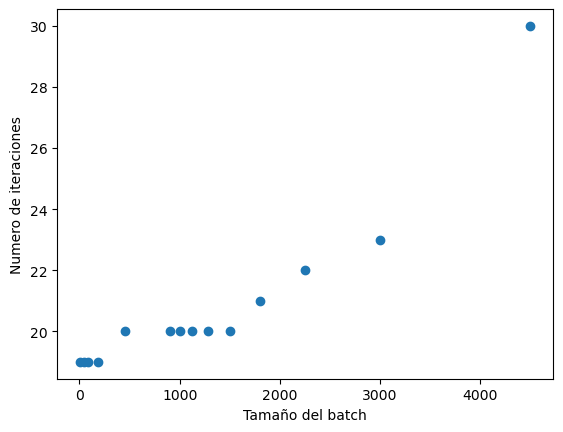

In [10]:
bateches = [int(n/2), int(n/3),int(n/4),int(n/5),int(n/6),int(n/7),int(n/8),int(n/9),int(n/10), int(n/20), int(n/50), int(n/100), int(n/200), 1]

numero_iteraciones = []

n = A.shape[0]

for batch_size in bateches:
    
    print(f"Calculando n = {batch_size}")
    
    A = A_original.copy()
    M = M_original.copy()
    X = X_original.copy()
    
    (_, errores) = src.coordinate_descent_random_filas(A,d,batch_size)
    numero_iteraciones.append(len(errores))

plt.scatter(bateches,numero_iteraciones)
plt.ylabel("Numero de iteraciones")
plt.xlabel("Tamaño del batch")


## Implementacion paralela

Se procede a realizar la implementacion paralela de la anterior funcion por batch.
Es importante notar que es pesada el calculo de la funcion de costo, es por eso que se deja su aplicacion opcional con el fin de poder medir el tiempo. Una correcta implementacion tambien deberia implementar dicha funcion en paralelo. 


In [ ]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Parrallel Coordinate descent")
start_cd_r_p = timeit.default_timer()
n = A.shape[0]
(X_cd_r_p, errores) = src.coordinate_descent_random_filas_parallel(A,d,int(n/3), p=6, utilizar_fun_costo=False, num_iteraciones = 20, verbose=True)
stop_cd_r_p = timeit.default_timer()
time_cd_r_p = round(stop_cd_r_p-start_cd_r_p,3)
print("Done in ",time_cd_r_p," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate parrallel descent random            ",time_cd_r_p,"\t\t", src.cost_function(A,X_cd_r_p,M))




Running Parrallel Coordinate descent
Iteracion: 0 | Error absoluto: -1 | norma R: 8096.464707970219
Iteracion: 1 | Error absoluto: -1 | norma R: 14350.498748106385
Iteracion: 2 | Error absoluto: -1 | norma R: 5452.334527372388
Iteracion: 3 | Error absoluto: -1 | norma R: 8270.692737627807
Iteracion: 4 | Error absoluto: -1 | norma R: 4219.233560833726
Iteracion: 5 | Error absoluto: -1 | norma R: 4101.054170909703
Iteracion: 6 | Error absoluto: -1 | norma R: 3524.6615237748433
Iteracion: 7 | Error absoluto: -1 | norma R: 3496.9346773863062
Iteracion: 8 | Error absoluto: -1 | norma R: 3454.020250220705
Iteracion: 9 | Error absoluto: -1 | norma R: 3453.870107774597
Iteracion: 10 | Error absoluto: -1 | norma R: 3450.1053973297844
Iteracion: 11 | Error absoluto: -1 | norma R: 3450.5857472957787
Iteracion: 12 | Error absoluto: -1 | norma R: 3450.3921079972356
Iteracion: 13 | Error absoluto: -1 | norma R: 3450.6320002318944
Iteracion: 14 | Error absoluto: -1 | norma R: 3450.7037606183553
Itera

## Pruebas de tiempo y costo
Finalmente, realizamos las pruebas de tiempo e iteración variando el número de procesadores (hasta 6) y el numero de iteraciones. 
Se debería observar una mayor diferencia entre el número de procesadores cuando el batch aumenta. 
Idealmente, el costo caería poco al aumentar el batch, y el tiempo debería tender a disminuir de forma lineal al numero de procesadores. 

In [23]:

def ejecutar_pruebas(num_iteraciones):
    tiempos = []
    costos = []

    A = A_original.copy()
    n = A.shape[0]

    n_cores = [1,2,3,4,5,6]
    bateches = [int(n/3),int(n/4),int(n/5),int(n/6),int(n/7),int(n/8),int(n/9),int(n/10), int(n/20), int(n/50), int(n/100), int(n/200)]

    A = A_original.copy()
    n = A.shape[0]

    for cor in n_cores:

        tiempo_corr = []
        costos_corr = []

        for bat in bateches:
            

            A = A_original.copy()
            M = M_original.copy()
            X = X_original.copy()

            print("###### " + str(cor) + " | " + str(bat))
            
            start_cd_r_p = timeit.default_timer()
            
            n = A.shape[0]
            (X_cd_r_p, _) = src.coordinate_descent_random_filas_parallel(A,d,batch_size = bat, p=cor, utilizar_fun_costo= False, num_iteraciones= num_iteraciones)
            c = src.cost_function(A,X_cd_r_p,M)
            stop_cd_r_p = timeit.default_timer()
            time_cd_r_p = round(stop_cd_r_p-start_cd_r_p,3)

            tiempo_corr.append(time_cd_r_p)
            costos_corr.append(c)


        tiempos.append(tiempo_corr)
        costos.append(costos_corr)


    plt.figure(figsize=(12, 8))
    plt.title("Tiempos (S) con " + str(num_iteraciones) + " iteraciones")
    plt.imshow(tiempos, cmap='viridis')
    plt.colorbar(label='Values')
    plt.xticks(range(len(bateches)), bateches)
    plt.yticks(range(len(n_cores)), n_cores)
    plt.xlabel('Batch')
    plt.ylabel('Threads')

    for i,_ in enumerate(n_cores):
        for j, _ in enumerate(bateches):
            print (i,j)
            plt.text(j, i, f"{tiempos[i][j]:.2f}", ha='center', va='center', color='black')

    plt.show()



    plt.figure(figsize=(12, 8))
    plt.title("Loss con " + str(num_iteraciones) + " iteraciones")
    plt.imshow(costos, cmap='viridis')
    plt.colorbar(label='Values')
    plt.xticks(range(len(bateches)), bateches)
    plt.yticks(range(len(n_cores)), n_cores)
    plt.xlabel('Batch')
    plt.ylabel('Threads')
    plt.show()



##### Ejecutar pruebas con 20 iteraciones

###### 1 | 3000
Iteracion: 0 | Error absoluto: -1 | norma R: 8213.64523762977
Iteracion: 1 | Error absoluto: -1 | norma R: 17090.90343189224
Iteracion: 2 | Error absoluto: -1 | norma R: 6352.31113665842
Iteracion: 3 | Error absoluto: -1 | norma R: 7679.5511199203675
Iteracion: 4 | Error absoluto: -1 | norma R: 4180.623867810741
Iteracion: 5 | Error absoluto: -1 | norma R: 4047.9202682993496
Iteracion: 6 | Error absoluto: -1 | norma R: 3520.1467254238687
Iteracion: 7 | Error absoluto: -1 | norma R: 3497.596768462957
Iteracion: 8 | Error absoluto: -1 | norma R: 3454.5611737979893
Iteracion: 9 | Error absoluto: -1 | norma R: 3453.647624506968
Iteracion: 10 | Error absoluto: -1 | norma R: 3449.966023446905
Iteracion: 11 | Error absoluto: -1 | norma R: 3450.5567110786856
Iteracion: 12 | Error absoluto: -1 | norma R: 3450.4316584131675
Iteracion: 13 | Error absoluto: -1 | norma R: 3450.6723286724405
Iteracion: 14 | Error absoluto: -1 | norma R: 3450.723773272529
Iteracion: 15 | Error absolut

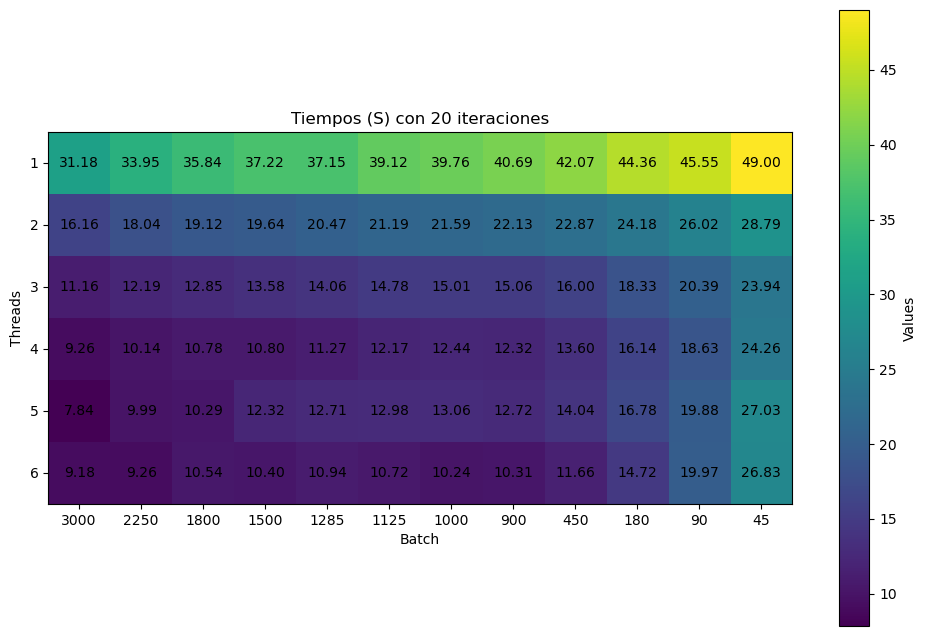

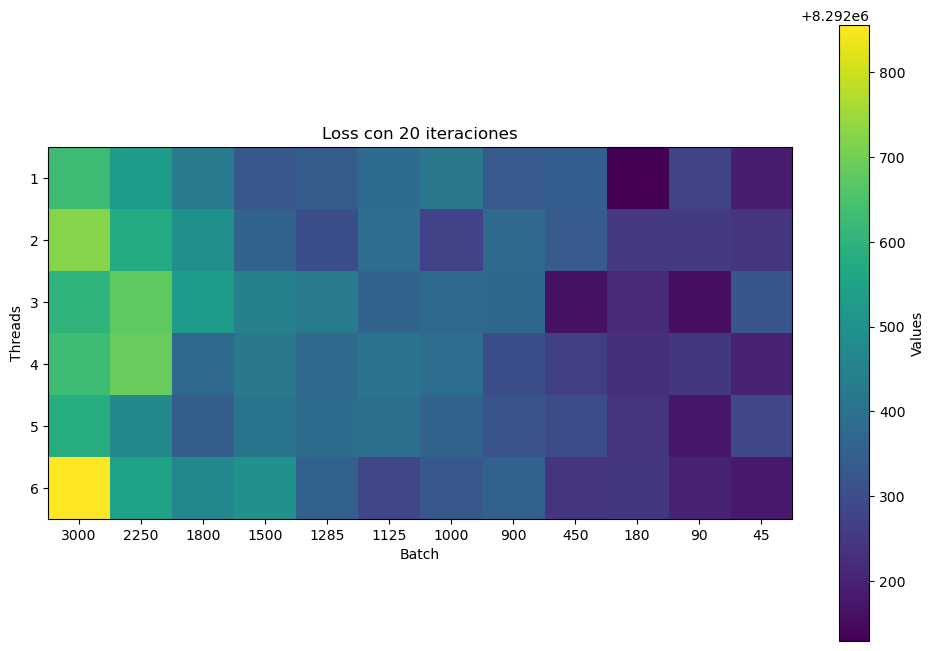

In [24]:
ejecutar_pruebas(20)

##### Ejecutar pruebas con 40 iteraciones

###### 1 | 3000
Iteracion: 0 | Error absoluto: -1 | norma R: 8124.895961693604
Iteracion: 1 | Error absoluto: -1 | norma R: 13878.90420842911
Iteracion: 2 | Error absoluto: -1 | norma R: 5323.138251137755
Iteracion: 3 | Error absoluto: -1 | norma R: 6540.343676622584
Iteracion: 4 | Error absoluto: -1 | norma R: 3977.9721005155448
Iteracion: 5 | Error absoluto: -1 | norma R: 3974.8273858328
Iteracion: 6 | Error absoluto: -1 | norma R: 3514.1391276368627
Iteracion: 7 | Error absoluto: -1 | norma R: 3490.956351983869
Iteracion: 8 | Error absoluto: -1 | norma R: 3453.616446534634
Iteracion: 9 | Error absoluto: -1 | norma R: 3452.914455680747
Iteracion: 10 | Error absoluto: -1 | norma R: 3450.034474385846
Iteracion: 11 | Error absoluto: -1 | norma R: 3450.498953902886
Iteracion: 12 | Error absoluto: -1 | norma R: 3450.404305176825
Iteracion: 13 | Error absoluto: -1 | norma R: 3450.6252502130046
Iteracion: 14 | Error absoluto: -1 | norma R: 3450.6844532585
Iteracion: 15 | Error absoluto: -1 

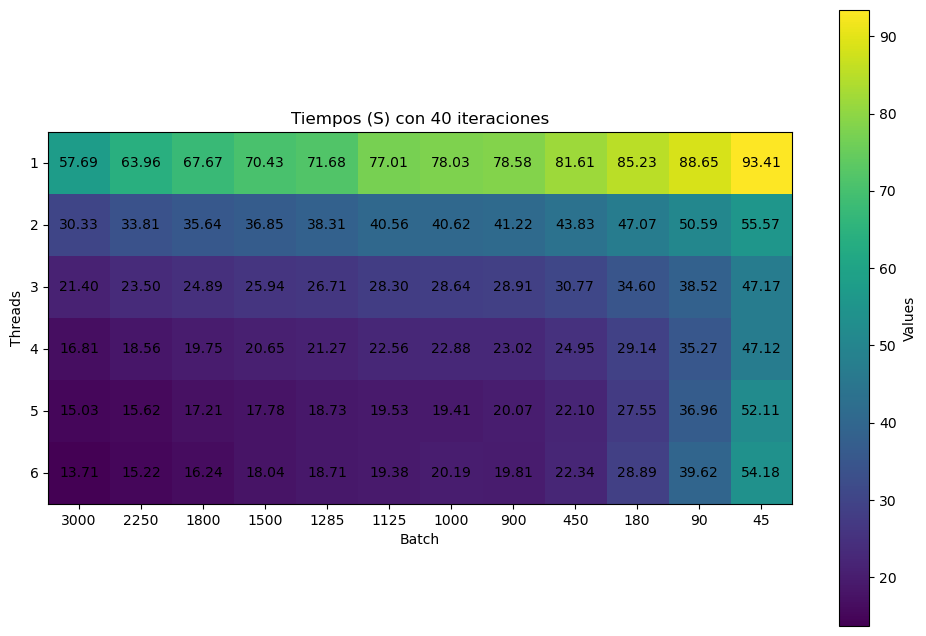

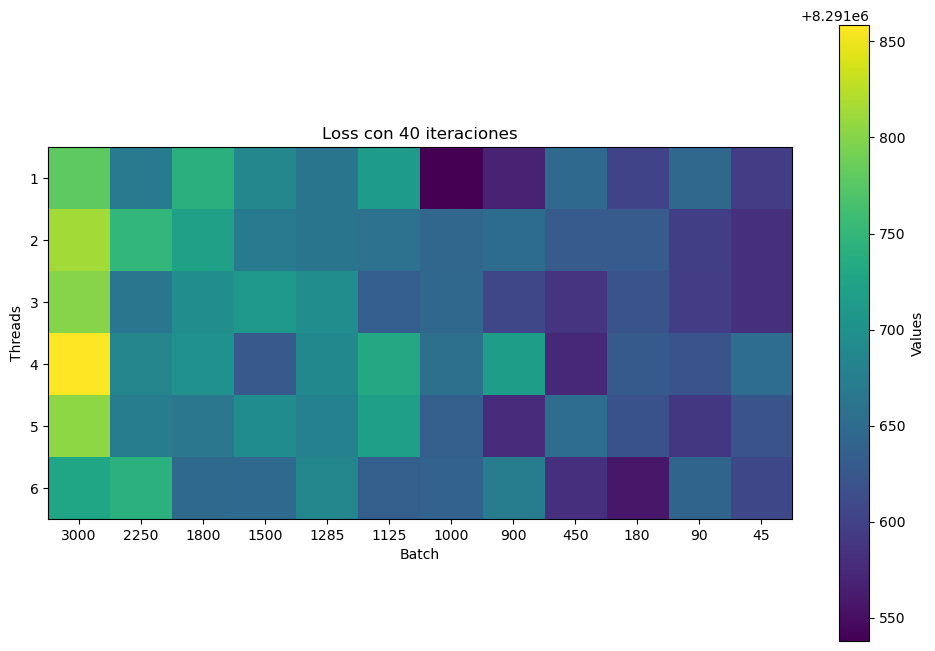

In [25]:
ejecutar_pruebas(40)